In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Mean scaling

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/marcopeix/time-series-analysis/master/data/medium_views_published_holidays.csv')
df['ds'] = pd.to_datetime(df['ds'])

df.head()

,unique_id,ds,y,published,is_holiday
0,0,2020-01-01,1131,0.0,1
1,0,2020-01-02,1764,0.0,0
2,0,2020-01-03,1699,0.0,0
3,0,2020-01-04,1322,0.0,0
4,0,2020-01-05,1491,0.0,0


In [3]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))

    return x/mean

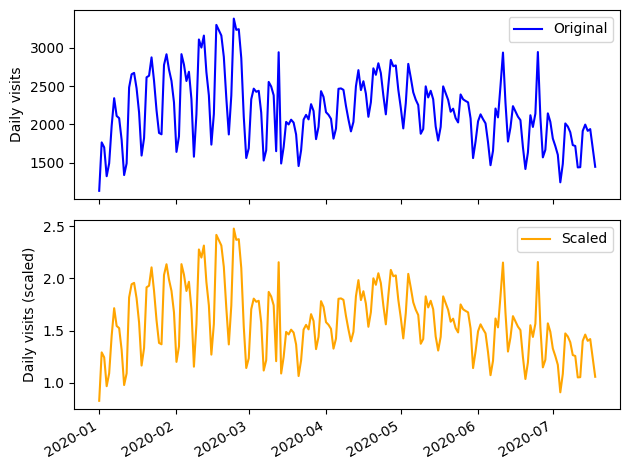

In [4]:
y = df['y'].values
y_scaled = mean_scaling(y)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:200], y[:200], color='blue', label='Original')
ax1.set_ylabel('Daily visits')
ax1.legend()

ax2.plot(df['ds'][:200], y_scaled[:200], color='orange', label='Scaled')
ax2.set_ylabel('Daily visits (scaled)')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Quantization

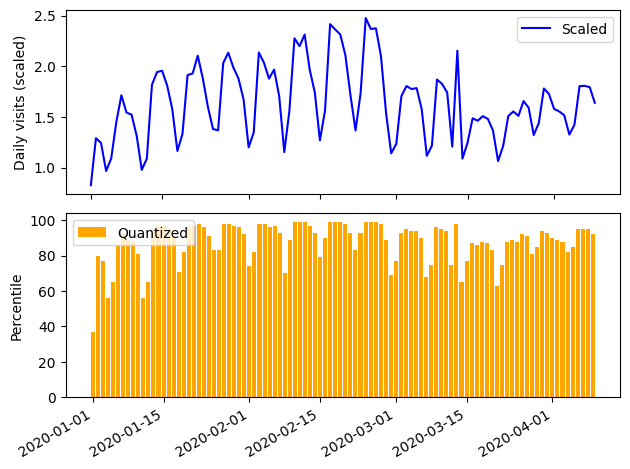

In [5]:
bins = pd.qcut(y_scaled, q=100, labels=False)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(df['ds'][:100], y_scaled[:100], color='blue', label='Scaled')
ax1.set_ylabel('Daily visits (scaled)')
ax1.legend()

ax2.bar(df['ds'][:100], bins[:100], color='orange', label='Quantized')
ax2.set_ylabel('Percentile')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()

## Forecasting with Chronos

In [6]:
import time
from datasetsforecast.m3 import M3
from utilsforecast.losses import *
from utilsforecast.evaluation import evaluate
import torch
from chronos import ChronosPipeline

Y_df, *_ = M3.load(directory='./', group='Monthly')

/opt/conda/envs/chronos-nf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/chronos-nf/lib/python3.10/site-packages/datasetsforecast/m3.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(class_group.freq)


In [7]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

horizon = 12

actual = []
preds = []

start = time.time()
for i in range(1, 1429):
    df = Y_df[Y_df['unique_id'] == f"M{i}"]

    actual.extend(df['y'][-horizon:].values)

    context = torch.tensor(df['y'].iloc[:-horizon].values)

    forecast = pipeline.predict(context, horizon)
    predictions = np.quantile(forecast[0].numpy(), [0.5], axis=0)

    preds.extend(predictions[0])

chronos_duration = time.time() - start

results_df = pd.DataFrame({
    'target': actual,
    'chronos': preds
})

print(chronos_duration)

1200.7771408557892


### Testing N-BEATS and MLP

In [8]:
from neuralforecast.models import MLP, NBEATS
from neuralforecast.losses.pytorch import HuberLoss
from neuralforecast.core import NeuralForecast

horizon = 12
val_size = 12
test_size = 12

mlp = MLP(h=horizon, input_size=3*horizon, loss=HuberLoss(), devices=1, accelerator='cpu')

start = time.time()
nf = NeuralForecast(models=[mlp], freq='M')
mlp_forecasts_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None, verbose=True)

mlp_duration = time.time() - start

mlp_forecasts_df.head()

print(mlp_duration)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Epoch 3:   9%|▉         | 4/45 [00:00<00:01, 34.83it/s, v_num=4, train_loss_step=575.0, train_loss_epoch=583.0, valid_loss=605.0] 

Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 173.84it/s]
35.28536629676819


In [9]:
nbeats = NBEATS(h=horizon, input_size=3*horizon, loss=HuberLoss(), devices=1, accelerator='cpu')

start = time.time()
nf = NeuralForecast(models=[nbeats], freq='M')
nbeats_forecasts_df = nf.cross_validation(df=Y_df, val_size=val_size, test_size=test_size, n_windows=None, verbose=True)

nbeats_duration = time.time() - start

nbeats_forecasts_df.head()

print(mlp_duration)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Predicting DataLoader 0: 100%|██████████| 45/45 [00:00<00:00, 136.62it/s]
35.28536629676819


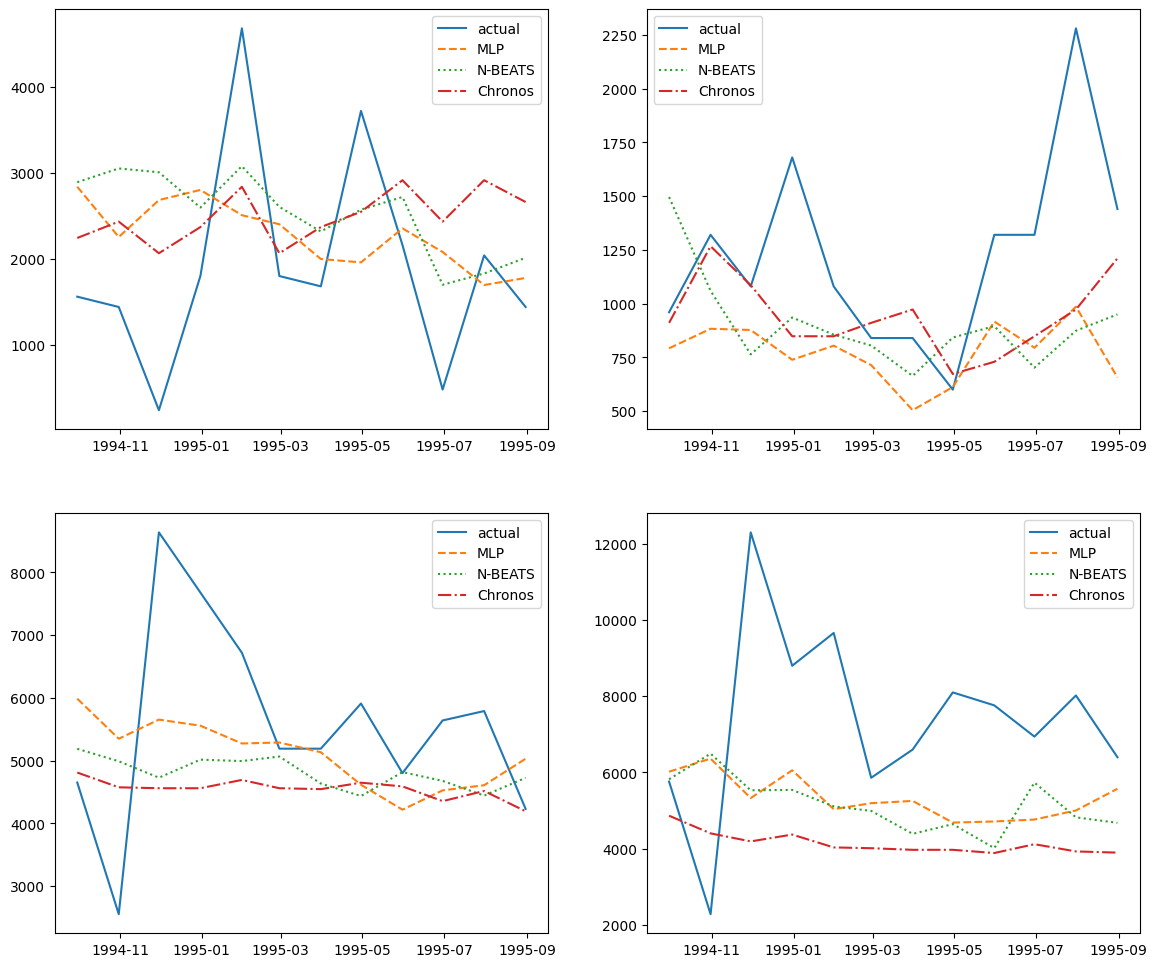

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))

for i, ax in enumerate(axes.flatten()):
    id = f"M{i+1}"
    mlp_to_plot = mlp_forecasts_df[mlp_forecasts_df['unique_id'] == id]
    nbeats_to_plot = nbeats_forecasts_df[nbeats_forecasts_df['unique_id'] == id]

    ax.plot(mlp_to_plot['ds'], mlp_to_plot['y'], label='actual')
    ax.plot(mlp_to_plot['ds'], mlp_to_plot['MLP'], ls='--', label='MLP')
    ax.plot(nbeats_to_plot['ds'], nbeats_to_plot['NBEATS'], ls=':', label='N-BEATS')
    ax.plot(nbeats_to_plot['ds'], preds[0+12*i:12+12*i], ls='-.', label='Chronos')

    ax.legend()

### Evaluation

In [15]:
from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

forecast_df = mlp_forecasts_df
forecast_df['NBEATS'] = nbeats_forecasts_df['NBEATS']

# Sort dataframe by id and date to align with the predictions of Chronos
forecast_df['SortKey'] = forecast_df['unique_id'].str.extract('(\d+)').astype(int)
forecast_df = forecast_df.sort_values(by=['SortKey', 'ds'])
forecast_df = forecast_df.drop(columns=['SortKey'])

forecast_df['Chronos'] = results_df['chronos']

evaluation = evaluate(
    forecast_df,
    metrics=[mae, smape],
    models=['MLP', 'NBEATS', 'Chronos'],
    target_col='y'
)

avg_metrics = evaluation.drop(columns='unique_id').groupby('metric').mean().reset_index()

avg_metrics

,metric,MLP,NBEATS,Chronos
0,mae,566.822735,556.521487,2840.268490
1,smape,0.064237,0.063240,0.275607
